In [1]:
from worldmodel.mwp import MWP
from worldmodel.loader import json_to_MWP

#### Let's take a simple example problem and load it into mathworld code

In [2]:
msp_name = "asdiv-0002"
dataset = "asdiv"
split = "train"

path = f"output_files/data/{dataset}/{split}/{msp_name}.json" # our annotations are stored here
msp = json_to_MWP(path)

We can print the body and question of the math story problem text

In [3]:
print(msp.body, msp.question)

Ellen has 6 more balls than Marin. Marin has 9 balls. How many balls does Ellen have?


and visualize the corresponding ground truth world model

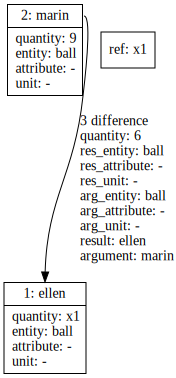

In [4]:
from utils.viz_helper import visualize_mwp_interactive

visualize_mwp_interactive(msp.final, msp_name)

# tip: if you want to save your plot you can use the function visualize_mwp_state 

The world model is a sequence of states, each corresponding to a sentence of the math story problem text. In the above plot we used the final state, but we can get any state we want:

In [5]:
print(msp.states)
print(msp.states[1].containers)

{0: <worldmodel.state.State object at 0x7f80c1497850>, 1: <worldmodel.state.State object at 0x7f80c1497b50>, 2: <worldmodel.state.State object at 0x7f80c1497e90>}
{1: Container(id=1,label=ellen,quantity=x1,entity=ball,attribute=None,unit=None), 2: Container(id=2,label=marin,quantity=9,entity=ball,attribute=None,unit=None)}


This math story problem makes use of the math concept "comparison" with type "add" (sec. 3.2.3 in the paper) which we render as "difference" in the figure. 

The first sentence corresponds to a _logical form_ with predicate "difference", the second sentence corresponds to a logical form of the container representing Marin's possession of balls, and the final question asks a question corresponding to the container representing Ellen's possession of balls. 

We can get the sentence logical forms by iterating over the states of the world model:

In [6]:
for i, state in enumerate(msp.states.values()):
    if i == len(msp.states)-1:
        print(f"Question logical form:", msp.compute_diff(i, sequence=True))
    else:
        print(f"State #{i} logical form:", msp.compute_diff(i, sequence=True))

# the question logical form determines the reference variable:
print("Reference variable:", msp.get_reference())
# note that x1 is the quantity of Ellen's container, which is what the question asks for

State #0 logical form: difference ( ellen , marin , 6 , ball , None , None , ball , None , None )
State #1 logical form: container ( marin , 9 , ball , None , None )
Question logical form: container ( ellen , None , ball , None , None )
Reference variable: x1


We can apply a reasoning algorithm over the world model to see whether the world model graph implies the correct answer to the math story problem. This effectively queries the world model with the reference expression.

In [7]:
from worldmodel.reasoner import DeterministicReasoner

reasoner = DeterministicReasoner(msp)
answer = reasoner.reason()
print("Ground truth:", msp.get_answer())
print("Reasoner predicts:", answer)

# tip: if we want to query the reasoner with another variable, 
#  we can change the reference variable using the method set_reference()

Ground truth: 15
Reasoner predicts: 15


#### What if we want to create a new world model?

Let's instantiate a new MWP object using the same metadata as the math story problem above

In [8]:
msp_copy = MWP(problem_id=msp.id, body=msp.body, question=msp.question, spans=msp.spans)
print(msp_copy.id, "\n", msp_copy.body, "\n", msp_copy.question, "\n", msp_copy.spans)

asdiv-0002 
 Ellen has 6 more balls than Marin. Marin has 9 balls. 
 How many balls does Ellen have? 
 ['Ellen has 6 more balls than Marin.', 'Marin has 9 balls.', 'How many balls does Ellen have?']


But the object is empty of logical forms... Let's fix that by imputing the logical forms from above

In [9]:
from worldmodel.loader import update_world_model
for i, state in enumerate(msp.states.values()):
    update_world_model(msp_copy, msp.compute_diff(i, sequence=True))
    print(f"Updated copy state #{i} diff:", msp_copy.compute_diff(i, sequence=True))

print("Copy reference variable:", msp_copy.get_reference())

Updated copy state #0 diff: difference ( ellen , marin , 6 , ball , None , None , ball , None , None )
Updated copy state #1 diff: container ( marin , 9 , ball , None , None )
Updated copy state #2 diff: container ( ellen , None , ball , None , None )
Copy reference variable: x1


We can apply the reasoner and plot the new world model to verify that we get the same

Copy reasoner predicts: 15


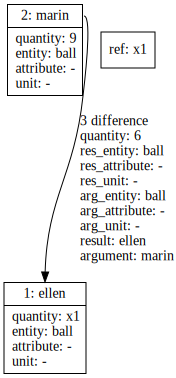

In [10]:
reasoner = DeterministicReasoner(msp_copy)
answer = reasoner.reason()
print("Copy reasoner predicts:", answer)
visualize_mwp_interactive(msp_copy.final, msp_name)

Btw! We can make sure we have a well-formed logical form before feeding it to the update function. This is useful if you get your logical form from a semantic parser (which may make mistakes) 

(however it is not necessary -- update_world_model already calls keep_well_formed before mutating the MWP object)

In [11]:
from worldmodel.loader import keep_well_formed
# this function removes all parts that are syntactically ill-formed

print(keep_well_formed(msp_copy.compute_diff(0, sequence=True)))

example_illformed = "difference ( this , is , an , ill , formed , difference , predicate)"
print(keep_well_formed(example_illformed)) # an empty print

difference ( ellen , marin , 6 , ball , none , none , ball , none , none )



#### Other math concepts

There are three other arithmetic math concepts covered by MathWorld! Here is another math story problem involing transfer and rate concepts:

Jerry is at the library helping put away books. There are 34 book to put away total. A librarian takes 7 of them and leaves Jerry with the rest. If he can fit 3 books on a shelf, how many shelves will he need?


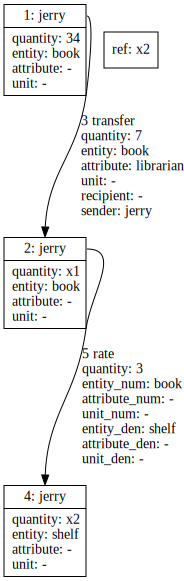

In [12]:
msp_name = "mawps-120"
dataset = "mawps"
split = "train"

path = f"output_files/data/{dataset}/{split}/{msp_name}.json" # our annotations are stored here
msp2 = json_to_MWP(path)

print(msp2.body, msp2.question)
visualize_mwp_interactive(msp2.final, msp_name)